knn, random forest, xgboost

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
# read in data
ifood = pd.read_csv('ifood_df.csv')

In [3]:
# data preprocessing

# remove unneeded columns
ifood_rdu = ifood.drop(['Z_CostContact', 'Z_Revenue', 'MntTotal', 'MntRegularProds', 'AcceptedCmpOverall'], axis=1)

# split data into response and predictor variables
X = ifood_rdu.loc[:, ifood_rdu.columns != 'Response']
y = ifood_rdu['Response']

In [4]:
# 70-30 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

# k-Nearest Neighbors

In [22]:
# hyperparameter tuning (number of neighbors)

# define a list of possible k values (odd to avoid ties)
k = list(range(1,26,2))
param_grid = {'n_neighbors': k}

# initialize the knn model
knn = KNeighborsClassifier()

# perform grid search with cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# print best k value
print(grid_search.best_params_)

{'n_neighbors': 15}


In [46]:
# define final model with the best hyperparameters
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)

# predict on the training data
y_pred = knn.predict(X_test)

# get confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# get values of positive class
y_scores = knn.predict_proba(X_test)[:, 1] 

# print performance metrics
print(confusion_matrix(y_test, y_pred))
print('AUC with k=15:', roc_auc_score(y_test, y_pred))
print('Average precision with k=15:', average_precision_score(y_test, y_scores))

[[567  14]
 [ 70  11]]
AUC with k=15: 0.5558530417968169
Average precision with k=15: 0.2585876885291195


# Random Forest

In [11]:
# initialize the random forest classifier
rf = RandomForestClassifier(random_state = 12345)

# define a list of possible hyperparameter values
param_grid = {
    'bootstrap': [True],
    'class_weight': ['balanced'],
    'max_depth': [9, 10, 11, 12],
    'max_features': [9],
    'min_samples_split': [5],
    'n_estimators': [100]
}

# perform grid serach with cross-validation
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 10)
grid_search.fit(X_train, y_train)

# print the best hyperparameter values
print(grid_search.best_params_)

c:\Users\marie\anaconda3\envs\AnalyticsFoundations\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 9, 'max_features': 9, 'min_samples_split': 5, 'n_estimators': 100}


In [47]:
# define the model with the best hyperparameters
rf = RandomForestClassifier(bootstrap = True,
                            class_weight = 'balanced',
                            max_depth = 8,
                            max_features = 11,
                            min_samples_split = 6,
                            n_estimators = 100,
                            random_state = 12345)
rf.fit(X_train, y_train)

# predict on the test data
y_pred = rf.predict(X_test)

# get confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# get values of positive class
y_scores = rf.predict_proba(X_test)[:, 1] 

# print performance metrics
print(confusion_matrix(y_test, y_pred))
print('AUC:', roc_auc_score(y_test, y_pred))
print('Average precision:', average_precision_score(y_test, y_scores))

[[547  34]
 [ 33  48]]
AUC: 0.76703639956652
Average precision: 0.6251381753922742


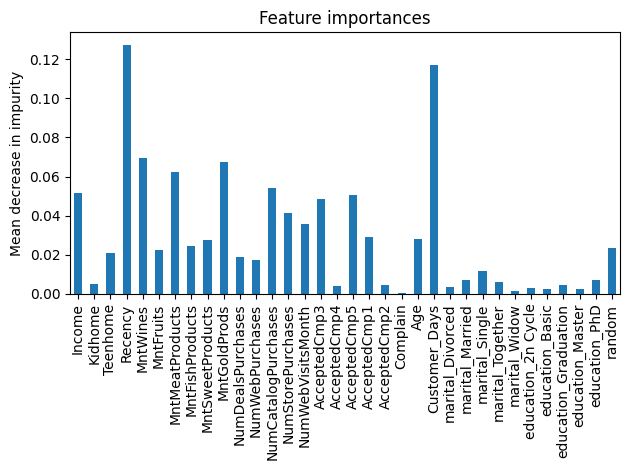

In [49]:
# variable selection (random variable method)

# copy the training data and add a random variable
X_train_r = X_train.copy()
X_train_r['random'] = np.random.normal(0, 1, 1543)

# build the random forest model with the random variable 
rf_random = RandomForestClassifier(bootstrap = True,
                                   class_weight = 'balanced',
                                   max_depth = 8,
                                   max_features = 11,
                                   min_samples_split = 6,
                                   n_estimators = 100,
                                   random_state = 12345)
rf_random.fit(X_train_r, y_train)

# save the importance metrics into an object
rf_importances = pd.Series(rf_random.feature_importances_, index = rf_random.feature_names_in_)

# plot the importance metrics
fig, ax = plt.subplots()
rf_importances.plot.bar(ax = ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

plt.show()

In [40]:
# re-tuning parameters with reduced model
X_train_rdu = X_train[['Income', 'Recency', 'MntWines', 'MntMeatProducts', 'MntGoldProds',
                       'NumCatalogPurchases', 'NumStorePurchases','NumWebVisitsMonth',
                       'AcceptedCmp3', 'AcceptedCmp5', 'AcceptedCmp1', 'Age', 'Customer_Days']]

# initialize the random forest classifier
rf = RandomForestClassifier(random_state = 12345)

# define a list of possible hyperparameter values
param_grid = {
    'bootstrap': [True],
    'class_weight': ['balanced'],
    'max_depth': [3, 4, 5, 6, 7],
    'max_features': [3, 4, 5, 6, 7],
    'min_samples_split': [3, 4, 5, 6, 7],
    'n_estimators': [100, 200, 300, 400, 500]
}

# perform grid serach with cross-validation
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 10)
grid_search.fit(X_train_rdu, y_train)

# print the best hyperparameter values
print(grid_search.best_params_)

c:\Users\marie\anaconda3\envs\AnalyticsFoundations\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'bootstrap': True, 'max_depth': 6, 'max_features': 5, 'min_samples_split': 6, 'n_estimators': 100}


In [ ]:
# reduce variables from the test data
X_test_rdu = X_test[['Income', 'Recency', 'MntWines', 'MntMeatProducts', 'MntGoldProds',
                       'NumCatalogPurchases', 'NumStorePurchases','NumWebVisitsMonth',
                       'AcceptedCmp3', 'AcceptedCmp5', 'AcceptedCmp1', 'Age', 'Customer_Days']]

In [ ]:
# define the final model with the best hyperparameters
rf = RandomForestClassifier(bootstrap = True,
                            class_weight = 'balanced',
                            max_depth = 8,
                            max_features = 11,
                            min_samples_split = 6,
                            n_estimators = 100,
                            random_state = 12345)
rf.fit(X_train_rdu, y_train)

# predict on the test data
y_pred = rf.predict(X_test_rdu)

# get confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# get values of positive class
y_scores = rf.predict_proba(X_test)[:, 1] 

# print performance metrics
print(confusion_matrix(y_test, y_pred))
print('AUC:', roc_auc_score(y_test, y_pred))
print('Average precision:', average_precision_score(y_test, y_scores))

# XGBoost

In [6]:
# initialize the XGBoost classifier
xgb = XGBClassifier(objective = 'binary:logistic', random_state = 12345)

# implement weighting to account for imblanaced responses
pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

# define a list of possible hyperparameter values
param_grid = {
    'scale_pos_weight': [pos_weight],
    'n_estimators': [50, 100, 200, 300, 400],
    'eta': [0.2],
    'max_depth': [7, 8, 9, 10, 11],
    'subsample': [0.75],
    'colsample_bytree': [1]
}

# perform a grid serach with cross-validation
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = 10)
grid_search.fit(X_train, y_train)

# print the best hyperparameter values
print(grid_search.best_params_)

{'colsample_bytree': 1, 'eta': 0.2, 'max_depth': 10, 'n_estimators': 300, 'scale_pos_weight': 5.123015873015873, 'subsample': 0.75}


In [7]:
# build model with best hyperparameter values
xgb = XGBClassifier(n_estimators = 300,
                    eta = 0.2,
                    max_depth = 10,
                    subsample = 0.75,
                    colsample_bytree = 1,
                    objective = 'binary:logistic',
                    random_state = 12345,
                    scale_pos_weight = pos_weight)
xgb.fit(X_train, y_train)

# predict on the test data
y_pred = xgb.predict(X_test)

# get confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# get values of positive class
y_scores = xgb.predict_proba(X_test)[:, 1] 

# print performance metrics
print(confusion_matrix(y_test, y_pred))
print('AUC:', roc_auc_score(y_test, y_pred))
print('Average precision:', average_precision_score(y_test, y_scores))

[[553  28]
 [ 41  40]]
AUC: 0.7228171947047448
Average precision: 0.6433787458651109


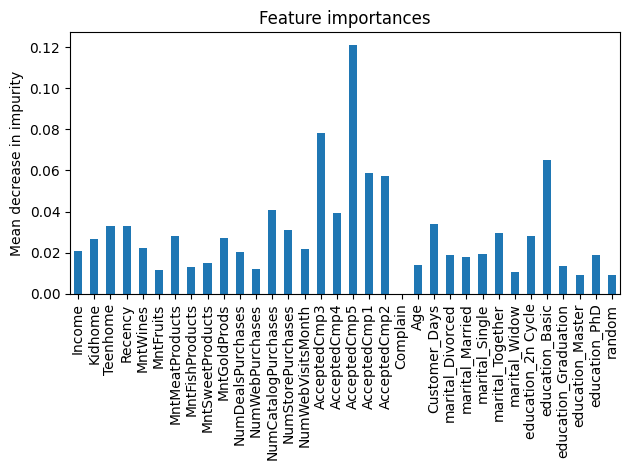

In [12]:
# variable selection (random variable method)

# copy the training data and add a random variable
X_train_r = X_train.copy()
X_train_r['random'] = np.random.normal(0, 1, 1543)

# build the xgboost model with the random variable
xgb_random = XGBClassifier(n_estimators = 300,
                           eta = 0.2,
                           max_depth = 10,
                           subsample = 0.75,
                           colsample_bytree = 1,
                           objective = 'binary:logistic',
                           random_state = 12345,
                           scale_pos_weight = pos_weight)
xgb_random.fit(X_train_r, y_train)

# save the importance metrics into an object
xgb_importances = pd.Series(xgb_random.feature_importances_, index = xgb_random.feature_names_in_)

# plot the feature importances
fig, ax = plt.subplots()
xgb_importances.plot.bar(ax = ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

plt.show()

In [6]:
# re-tuning parameters with reduced model
X_train_rdu = X_train.drop(['Complain', 'education_Graduation', 'education_Master', 'MntFruits',
                       'NumWebPurchases', 'marital_Widow'], axis=1)

# initialize the random forest classifier
xgb = XGBClassifier(objective = 'binary:logistic', random_state = 12345)

# implement weighting to account for imblanaced responses
pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

# define a list of possible hyperparameter values
param_grid = {
    'scale_pos_weight': [pos_weight],
    'n_estimators': [200],
    'eta': [0.1],
    'max_depth': [7, 8, 9, 10, 11],
    'subsample': [0.75],
    'colsample_bytree': [0.25]
}

# perform grid serach with cross-validation
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = 10)
grid_search.fit(X_train_rdu, y_train)

# print the best hyperparameter values
print(grid_search.best_params_)

{'colsample_bytree': 0.25, 'eta': 0.1, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 5.123015873015873, 'subsample': 0.75}


In [8]:
# reduce test data
X_test_rdu = X_test.drop(['Complain', 'education_Graduation', 'education_Master', 'MntFruits',
                       'NumWebPurchases', 'marital_Widow'], axis=1)

In [10]:
# build final model with best hyperparameter values
xgb = XGBClassifier(n_estimators = 200,
                    eta = 0.1,
                    max_depth = 7,
                    subsample = 0.75,
                    colsample_bytree = 0.25,
                    objective = 'binary:logistic',
                    random_state = 12345, scale_pos_weight = pos_weight)
xgb.fit(X_train_rdu, y_train)

# predict on the test data
y_pred = xgb.predict(X_test_rdu)

# get confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# get values of positive class
y_scores = xgb.predict_proba(X_test_rdu)[:, 1] 

# print performance metrics
print(confusion_matrix(y_test, y_pred))
print('AUC:', roc_auc_score(y_test, y_pred))
print('Average precision:', average_precision_score(y_test, y_scores))

[[552  29]
 [ 40  41]]
AUC: 0.7281294490129832
Average precision: 0.6051390907561129
